<a href="https://colab.research.google.com/github/VaninaBlas/Fraud-Detection/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicción de fraude en transacciones

Este modelo tiene como finalidad ser utilizada para detectar fraudes en pagos con tarjetas de crédito. Estos datos fueron generados con la biblioteca Faker Library, por lo tanto, son datos simulados.

Dataset: [Fraud Detection](https://www.kaggle.com/datasets/sameerk2004/fraud-detection-dataset?resource=download//)

## Búsqueda de datos

El dataset fue sacado de Kaggle y contiene estos atributos:


*   **Profession**: la profesión del usuario.
*   **Income**: los ingresos del usuario.
*   **Credit Card Number**: un número de tarjeta de crédito generado aleatoriamente para la transacción.
*   **Expiry**:  la fecha de vencimiento de la tarjeta de crédito.
*   **Security Code**: el código de seguridad (CVV) de la tarjeta de crédito.
*   **Fraud**:  indica si la transacción es fraudulenta (1) o legítima (0).







In [1]:
# Librerias
import pandas as pd

In [2]:
# Importar dataset
from google.colab import files
import io

filesUploaded = files.upload()

Saving fraud_detection.csv to fraud_detection.csv


In [60]:
data = pd.read_csv("fraud_detection.csv", sep=",")

In [61]:
data

,Profession,Income,Credit_card_number,Expiry,Security_code,Fraud
0,DOCTOR,42509,3515418493460774,07/25,251,1
1,DOCTOR,80334,213134223583196,05/32,858,1
2,LAWYER,91552,4869615013764888,03/30,755,1
3,LAWYER,43623,341063356109385,01/29,160,1
4,DOCTOR,22962,4707418777543978402,11/30,102,0
...,...,...,...,...,...,...
9995,DOCTOR,2705,502092127427,09/27,422,1
9996,LAWYER,37862,349490624391408,07/34,811,0
9997,ENGINEER,83152,4990903961714432,11/24,216,1
9998,DOCTOR,90620,4827611166572112,01/33,180,1


## Exploración del dataset

In [ ]:
data.head()

,Profession,Income,Credit_card_number,Expiry,Security_code,Fraud
0,DOCTOR,42509,3515418493460774,07/25,251,1
1,DOCTOR,80334,213134223583196,05/32,858,1
2,LAWYER,91552,4869615013764888,03/30,755,1
3,LAWYER,43623,341063356109385,01/29,160,1
4,DOCTOR,22962,4707418777543978402,11/30,102,0


In [ ]:
data.dtypes

,0
Profession,object
Income,int64
Credit_card_number,int64
Expiry,object
Security_code,int64
Fraud,int64


Para trabajar con nuestro modelo se necesita que todos los datos sean numéricos. Luego, deben ser convertidos en variables dummies.

Por el momento solo voy a convertir a Expiry porque podría ser útil para el análisis.

In [62]:
# Añadir 20 al año
data['Expiry'] = data['Expiry'].apply(lambda x: f"20{x[3:]}-{x[:2]}-01")
# Convertir la fecha a tipo datetime
data['Expiry'] = pd.to_datetime(data['Expiry'], format='%Y-%m-%d')
# Crear nuevas columnas para mes y año
data['month'] = data['Expiry'].dt.month
data['year'] = data['Expiry'].dt.year
data.drop('Expiry', axis=1, inplace=True)
data.head()

,Profession,Income,Credit_card_number,Security_code,Fraud,month,year
0,DOCTOR,42509,3515418493460774,251,1,7,2025
1,DOCTOR,80334,213134223583196,858,1,5,2032
2,LAWYER,91552,4869615013764888,755,1,3,2030
3,LAWYER,43623,341063356109385,160,1,1,2029
4,DOCTOR,22962,4707418777543978402,102,0,11,2030


In [ ]:
data.shape # Hay 10.000 datos

(10000, 7)

In [ ]:
data.describe()

,Income,Credit_card_number,Security_code,Fraud,month,year
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000
mean,49761.20600,3.851363e+17,863.587800,0.501600,6.526300,2029.321200
std,28837.72928,1.257950e+18,1484.424959,0.500022,3.448492,2.891205
min,1.00000,6.040296e+10,0.000000,0.000000,1.000000,2024.000000
25%,24863.75000,1.800137e+14,275.000000,0.000000,4.000000,2027.000000
50%,49483.00000,3.512440e+15,539.500000,1.000000,7.000000,2029.000000
75%,74483.00000,4.594779e+15,813.250000,1.000000,9.000000,2032.000000
max,99986.00000,4.999697e+18,9990.000000,1.000000,12.000000,2034.000000


In [ ]:
# Quería ver quién era el que tenía un ingreso de 1
data_min_income = data[data["Income"] == 1]
data_min_income

,Profession,Income,Credit_card_number,Security_code,Fraud,month,year
874,ENGINEER,1,2462987691734078,733,1,11,2031


In [ ]:
# se seleccionan solo columnas numéricas
data_numeric = data.select_dtypes(include=['number'])
# Correlación
correlation_matrix = data_numeric.corr()
correlation_matrix

,Income,Credit_card_number,Security_code,Fraud,month,year
Income,1.000000,0.013951,0.002793,0.007364,-0.002789,-0.016938
Credit_card_number,0.013951,1.000000,-0.004093,0.003155,0.007400,-0.007043
Security_code,0.002793,-0.004093,1.000000,-0.001246,-0.006078,-0.008205
Fraud,0.007364,0.003155,-0.001246,1.000000,0.006675,-0.018757
month,-0.002789,0.007400,-0.006078,0.006675,1.000000,-0.084695
year,-0.016938,-0.007043,-0.008205,-0.018757,-0.084695,1.000000


No hay correlación entre las variables numéricas

In [ ]:
data["Profession"].unique()

array(['DOCTOR', 'LAWYER', 'ENGINEER'], dtype=object)

Solo contamos con las profesiones: doctor, abogado e ingeniero.

In [ ]:
data['Profession'].value_counts()

,count
Profession,
DOCTOR,3379
LAWYER,3357
ENGINEER,3264


In [ ]:
data["year"].value_counts()

,count
year,
2028,1036
2029,1014
2025,1007
2030,1006
2031,997
2032,992
2026,987
2027,986
2033,962


## Visualizaciones de los datos

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data["Fraud"].value_counts()

,count
Fraud,
1,5016
0,4984


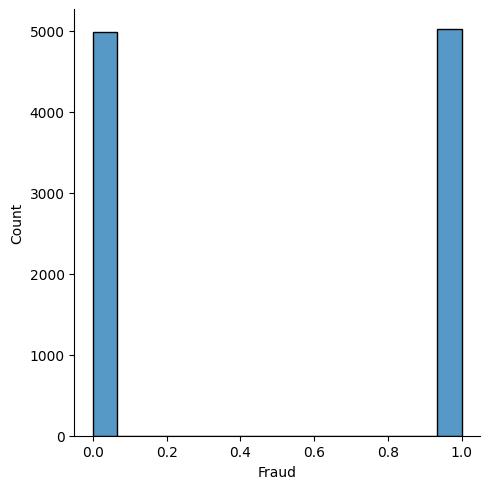

In [ ]:
sns.displot(data = data, x = "Fraud")

Fraud          0     1
Profession            
DOCTOR      1620  1759
ENGINEER    1688  1576
LAWYER      1676  1681


Text(0, 0.5, 'Fraud')

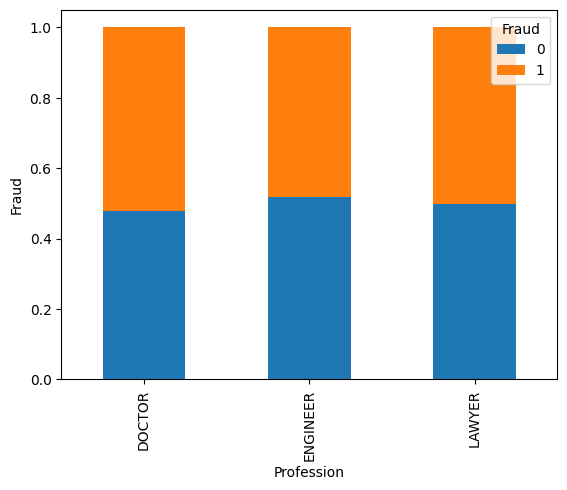

In [ ]:
# Relacionar profesión y fraude
tab = pd.crosstab(data["Profession"], data["Fraud"])
print(tab)
# Creamos un gráfico con la variable tab
tab.div(tab.sum(1).astype(float),axis=0).plot(kind="bar", stacked=True)
plt.xlabel("Profession")
plt.ylabel("Fraud")

No influye que profesión tenga

Fraud    0    1
year           
2024    79   89
2025   504  503
2026   478  509
2027   474  512
2028   500  536
2029   520  494
2030   494  512
2031   492  505
2032   510  482
2033   508  454
2034   425  420


Text(0, 0.5, 'Fraud')

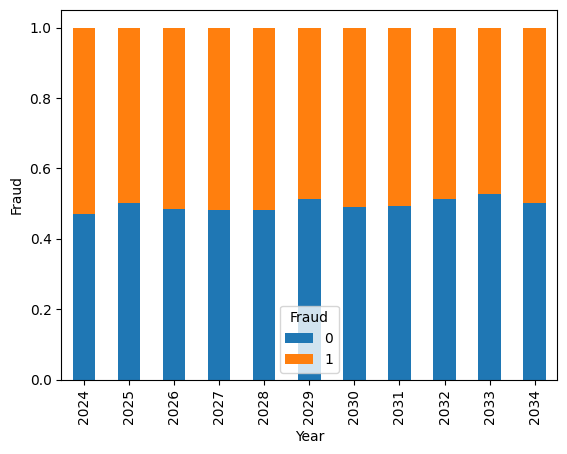

In [ ]:
# Relacionar año y fraude
tab = pd.crosstab(data["year"], data["Fraud"])
print(tab)
# Creamos un gráfico con la variable tab
tab.div(tab.sum(1).astype(float),axis=0).plot(kind="bar", stacked=True)
plt.xlabel("Year")
plt.ylabel("Fraud")

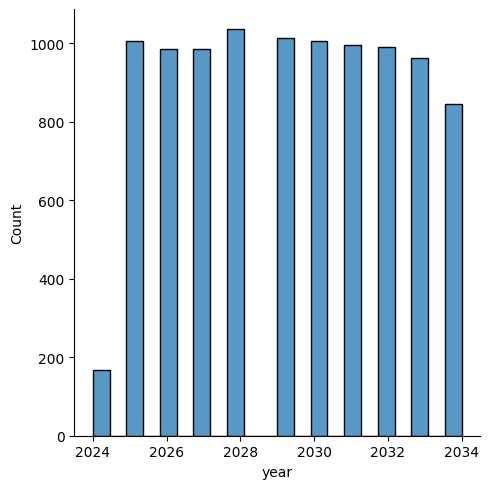

In [ ]:
sns.displot(data = data, x = "year")

In [ ]:
# Vemos los datos atípicos
def is_outlier(column):
  quantiles = column.quantile([0.25,0.75])
  iqr = quantiles.diff()[0.75]
  quantiles[0.25] -= (1.5 * iqr)
  quantiles[0.75] += (1.5 * iqr)

  return sum((column < quantiles[0.25]) | (column > quantiles[0.75])) > 0

print(data[["Income","Fraud",	"month",	"year"]].apply(is_outlier))

Income    False
Fraud     False
month     False
year      False
dtype: bool


No hay datos atípicos

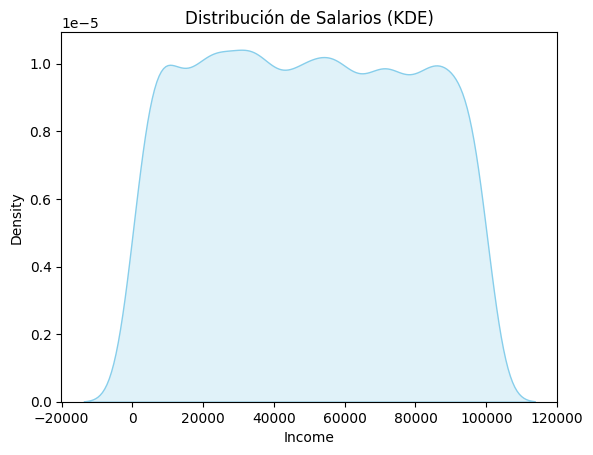

In [ ]:
sns.kdeplot(data['Income'], color='skyblue', fill=True)
plt.title('Distribución de Salarios (KDE)')
plt.show()

## Limpieza de datos

In [ ]:
data.isnull().sum()

,0
Profession,0
Income,0
Credit_card_number,0
Security_code,0
Fraud,0
month,0
year,0


No hay datos nulos.

## Convertir variables categóricas en variables numéricas

In [ ]:
data.dtypes

,0
Profession,object
Income,int64
Credit_card_number,int64
Security_code,int64
Fraud,int64
month,int32
year,int32


Solo tengo que encargarme de profesión.

In [63]:
data= pd.get_dummies(data, drop_first=True)
data = data.astype(int)

In [36]:
data

,Income,Credit_card_number,Security_code,Fraud,month,year,Profession_ENGINEER,Profession_LAWYER
0,42509,3515418493460774,251,1,7,2025,0,0
1,80334,213134223583196,858,1,5,2032,0,0
2,91552,4869615013764888,755,1,3,2030,0,1
3,43623,341063356109385,160,1,1,2029,0,1
4,22962,4707418777543978402,102,0,11,2030,0,0
...,...,...,...,...,...,...,...,...
9995,2705,502092127427,422,1,9,2027,0,0
9996,37862,349490624391408,811,0,7,2034,0,1
9997,83152,4990903961714432,216,1,11,2024,1,0
9998,90620,4827611166572112,180,1,1,2033,0,0


No está Profession_DOCTOR porque asume que si no es ENGINEER y LAWYER es DOCTOR

In [8]:
data.columns

Index(['Income', 'Credit_card_number', 'Security_code', 'Fraud', 'month',
       'year', 'Profession_ENGINEER', 'Profession_LAWYER'],
      dtype='object')

In [12]:
data.dtypes

,0
Income,int64
Credit_card_number,int64
Security_code,int64
Fraud,int64
month,int64
year,int64
Profession_ENGINEER,int64
Profession_LAWYER,int64


Ahora todas las variables son numéricas, se puede dividir los datos.

## Dividir los datos en variable a predecir y variables predictoras

In [64]:
data = data.drop(columns=['Credit_card_number', 'Security_code'])

Se eliminan columnas que no aportan en el modelo.

In [65]:
X = data.drop(columns = ["Fraud"])
y = data["Fraud"]

## Dividir los datos en entrenamiento y testeo

In [66]:
# Dividimos datos en train y test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20)

In [67]:
X_train

,Income,month,year,Profession_ENGINEER,Profession_LAWYER
2294,83349,3,2029,1,0
2808,97028,11,2028,0,1
6480,47967,2,2030,1,0
9202,86361,12,2026,0,1
3111,23640,8,2031,0,1
...,...,...,...,...,...
3915,51891,5,2034,0,1
9620,29389,7,2025,0,0
7068,53783,10,2027,1,0
7391,71723,2,2028,1,0


In [68]:
X_test

,Income,month,year,Profession_ENGINEER,Profession_LAWYER
9957,67715,10,2030,1,0
1687,86557,7,2032,0,1
2116,73499,12,2029,0,1
231,414,5,2033,1,0
2780,63817,9,2033,0,0
...,...,...,...,...,...
8514,89886,2,2031,1,0
5190,56353,1,2031,0,1
6766,57647,7,2027,0,0
347,87900,8,2025,0,0


In [69]:
y_train

,Fraud
2294,0
2808,1
6480,0
9202,0
3111,0
...,...
3915,1
9620,0
7068,1
7391,0


In [70]:
y_test

,Fraud
9957,1
1687,1
2116,0
231,0
2780,0
...,...
8514,0
5190,0
6766,1
347,1


In [71]:
print("El tamaño de X_train es: ", X_train.shape)
print("El tamaño de X_test es: ",X_test.shape)
print("El tamaño de y_train es: ",y_train.shape)
print("El tamaño de y_test es: ",y_test.shape)

El tamaño de X_train es:  (7500, 5)
El tamaño de X_test es:  (2500, 5)
El tamaño de y_train es:  (7500,)
El tamaño de y_test es:  (2500,)


## Entrenamiento

### Regresión Logística

In [72]:
#Importar modelo
from sklearn.linear_model import LogisticRegression

#Instansiar
LogReg = LogisticRegression(C=0.1,class_weight='balanced', solver='liblinear',random_state=0)
#Entrenamiento
LogReg.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight='balanced', random_state=0,
                   solver='liblinear')

In [73]:
# Primero debemos obtener las predicciones
pred = LogReg.predict(X_test)

# Exactitud
accuracy = (pred == y_test).sum() / pred.size
print("Exactitud: {}".format(accuracy))

# Precisión
precision = (pred + y_test == 2).sum() / pred.sum()
print("Precisión: {}".format(precision))

# Exhaustividad
recall = (pred + y_test == 2).sum() / y_test.sum()
print("Exhaustividad: {}".format(recall))

# Valor F
fScore = 2 * precision * recall / (precision + recall)
print("Valor F: {}".format(fScore))

Exactitud: 0.4964
Precisión: 0.5077519379844961
Exhaustividad: 0.5121188428459734
Valor F: 0.5099260412611911


### KNN

In [74]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [75]:
knn.score(X_train, y_train)

0.6850666666666667

In [76]:
knn.score(X_test, y_test)

0.5008

In [77]:
resultados_score_train = []
resultados_score_test = []
k_valor = [3,5,7,10,15]

for k in k_valor:
    knn = KNeighborsClassifier(k)
    knn.fit(X_train, y_train)
    resultados_score_train.append(knn.score(X_train, y_train))
    resultados_score_test.append(knn.score(X_test, y_test))


In [78]:
resultados_score_test

[0.4976, 0.5008, 0.514, 0.504, 0.4996]

In [79]:
resultados_score_train

[0.7508, 0.6850666666666667, 0.6562666666666667, 0.6205333333333334, 0.5976]

In [80]:
resultados=pd.DataFrame({"k":k_valor, "res_train":resultados_score_train, "res_test":resultados_score_test})

In [81]:
resultados

,k,res_train,res_test
0,3,0.750800,0.4976
1,5,0.685067,0.5008
2,7,0.656267,0.5140
3,10,0.620533,0.5040
4,15,0.597600,0.4996


### Random Forest

In [82]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators = 500, max_depth = 2, max_features = 3, bootstrap = True)
random_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, max_features=3, n_estimators=500)

In [83]:
random_forest.score(X_train, y_train)

0.5333333333333333

In [84]:
random_forest.score(X_test, y_test)

0.5104

In [85]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, random_forest.predict(X_test))

0.5104

## Conclusión

Todos los modelos dan un resultado alrededor de 0.5, ninguno sirve TT

Probablemente, faltan datos necesarios o hay que usar otros modelos o  hiperparámetros.